In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("movie_data.csv")

In [6]:
# 1. Data Cleaning
df.drop_duplicates(inplace=True)

def convert_duration(d):
    if isinstance(d, str):
        parts = d.split()
        minutes = 0
        for p in parts:
            if "h" in p:
                minutes += int(p.replace("h", "")) * 60
            elif "min" in p:
                minutes += int(p.replace("min", ""))
        return minutes
    return np.nan

df["duration_minutes"] = df["duration"].apply(convert_duration)

imputer = SimpleImputer(strategy="median")
df["duration_minutes"] = imputer.fit_transform(df[["duration_minutes"]])

Q1 = df["rating"].quantile(0.25)
Q3 = df["rating"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df = df[(df["rating"] >= lower) & (df["rating"] <= upper)].reset_index(drop=True)

In [7]:
# 2. Normalisasi/Standarisasi
scaler = StandardScaler()
df[["year_scaled", "duration_scaled"]] = scaler.fit_transform(df[["year", "duration_minutes"]])

In [8]:
# 3. Encoding kategorikal
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
# Fit and transform the genre column
genre_encoded = encoder.fit_transform(df[["genre"]])
# Create a new DataFrame with the encoded columns
genre_encoded_df = pd.DataFrame(genre_encoded, columns=encoder.get_feature_names_out(["genre"]))
# Concatenate the new encoded columns with the original DataFrame
df = pd.concat([df, genre_encoded_df], axis=1)

In [9]:
# 4. Feature Engineering

# Menghitung usia film
CURRENT_YEAR = 2025
df['movie_age'] = CURRENT_YEAR - df['year']
df.drop('year', axis=1, inplace=True)
numeric_cols = ['rating', 'duration_min', 'movie_age']

In [14]:
# 5. SPLIT DATA

# Define the final feature columns explicitly
# 1. Get the names of the new one-hot encoded genre columns
encoded_genre_cols = encoder.get_feature_names_out(['genre']).tolist()
# 2. Define the other numerical columns we created
numerical_cols = ['year_scaled', 'duration_scaled', 'movie_age']

# 3. Combine the lists to create our final feature set
feature_cols = numerical_cols + encoded_genre_cols

# Create the feature matrix X using only the selected columns
X = df[feature_cols]
y = df["rating"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)

Shape X_train: (191, 99)
Shape X_test : (48, 99)


In [11]:
# A1. Implementasi Model Supervised Learning (Regresi)

# Model 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Linear Regression Model berhasil dilatih.")

# Model 2 (Point Plus): Support Vector Regressor (SVR)
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)
print("Support Vector Regressor Model berhasil dilatih.")

Linear Regression Model berhasil dilatih.
Support Vector Regressor Model berhasil dilatih.


In [12]:
# A2. Evaluasi Hasil Prediksi

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"Hasil Evaluasi untuk {model_name}:")
    print(f"  - MAE : {mae:.4f}")
    print(f"  - MSE : {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - R2-Score: {r2:.4f}\n")
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

lr_metrics = evaluate_model(y_test, y_pred_lr, "Linear Regression")
svr_metrics = evaluate_model(y_test, y_pred_svr, "Support Vector Regressor")

Hasil Evaluasi untuk Linear Regression:
  - MAE : 0.6380
  - MSE : 0.6737
  - RMSE: 0.8208
  - R2-Score: -0.2251

Hasil Evaluasi untuk Support Vector Regressor:
  - MAE : 0.5783
  - MSE : 0.5372
  - RMSE: 0.7329
  - R2-Score: 0.0231



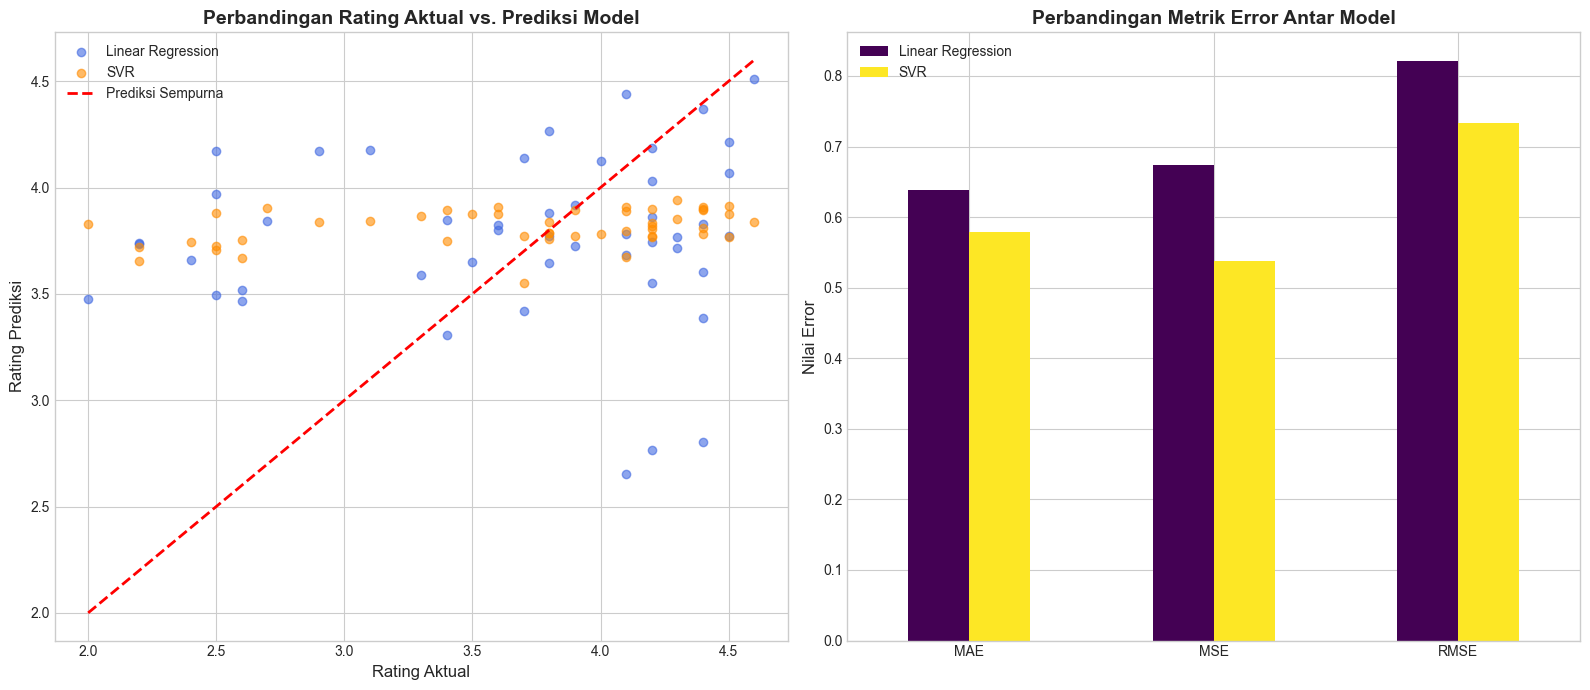

In [13]:
# A3. Visualisasi Hasil Prediksi
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Actual vs. Predicted
axes[0].scatter(y_test, y_pred_lr, alpha=0.6, label='Linear Regression', color='royalblue')
axes[0].scatter(y_test, y_pred_svr, alpha=0.6, label='SVR', color='darkorange')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Prediksi Sempurna')
axes[0].set_title('Perbandingan Rating Aktual vs. Prediksi Model', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating Aktual', fontsize=12)
axes[0].set_ylabel('Rating Prediksi', fontsize=12)
axes[0].legend()

# Plot 2: Evaluation Metrics
metrics_df = pd.DataFrame({'Linear Regression': [lr_metrics['MAE'], lr_metrics['MSE'], lr_metrics['RMSE']],
                           'SVR': [svr_metrics['MAE'], svr_metrics['MSE'], svr_metrics['RMSE']]},
                          index=['MAE', 'MSE', 'RMSE'])
metrics_df.plot(kind='bar', ax=axes[1], colormap='viridis')
axes[1].set_title('Perbandingan Metrik Error Antar Model', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Nilai Error', fontsize=12)
axes[1].set_xticklabels(metrics_df.index, rotation=0)

plt.tight_layout()
plt.show()

# Kesimpulan Analisis Data
1. Data cleaning
   - Untuk missing values pada nilai null dan duplikat tidak ada
   - Konversi Durasi dari teks "1h 39m" menjadi kolom numerik dengan label duration_minutes dalam numerik
   - Outlier pada rating dihapus menggunakan IQR, setelah pembersihan data berkurang menjadi 239.
2. Normalisasi/Standarisasi
   Kolom numerik year, rating, dan duration_minutes diubah skalanya menggunakan StandardScaler. mentransformasi data memiliki rata" nol dan deviasi  satu. Hasil standarisasi disimpan di kolom year_scaled, rating_scaled, dan duration_scaled.
3. Encoding Kategorikal
    genre yang bersifat kategorikal diubah menjadi representasi numerik menggunakan one-hot encoding
   - Kolom genre yuang berisi data teks diubah menjadi format numerik yang dapat diproses oleh model menggunakan One-Hot Encoding
   - Setiap genre yang unik diubah menjadi sebuah kolom biner baru. Nilai 1 pada kolom tersebut menandakan film memiliki genre tersebut, dan 0 sebaliknya
   - Output encoding digabung ke dataframe utama.
4. Feature Engineering
    movie_age dibuat dengan menghitung selisih antara tahun acuan, yaitu 2025 dan tahun rilis film. Untuk mendapatkan informasi umur film.
5. Split Data
    Data disiapkan untuk pelatihan model machine learning
    - Target(y): kolom yang diprediksi "rating"
    - Fitur (x): Semua kolom lain kecuali kolom yang tidak relevan(rating, duration, description, name, director, stars) dan termasuk semua kolom hasil preprocessing(duration_minutes, year_scaled, rating_scaled, duration_scaled, kolom hasil encoding dan movie_age)
    - Data dibagi menjadi data training set dan data test set dengan rasio 80:20
    - Xtrain:(191, 99 kolom)
    - xtest:(48 baris, 99 kolom)
6. A1 Implementasi Model Regresi
   Karena target prediksi (rating) adalah nilai numerik yang berkelanjutan, maka pendekatan yang digunakan adalah Regresi.
   - Linear Regression: Model ini bekerja dengan mencari hubungan linear (pola garis lurus) terbaik antara fitur-fitur (seperti umur, durasi, dan genre) dengan rating. Model ini mencoba menemukan persamaan matematis yang paling pas untuk meminimalkan kesalahan prediksi.
   - Support Vector Regressor (SVR): SVR ini mencoba menemukan margin toleransi disekitar garis prediksi. Prediksi untuk titik ata yang jatuh di dalam margin ini dianggap tidak memiliki error.
7. A2 Evaluasi Hasil Prediksi
   Kinerja kedua model diukur menggunakan metrik evaluasi regresi standar:
   - MAE: Rata-rata dari selisih absolut antara nilai prediksi dan nilai asli. Semakin kecil, semakin baik.
   - MSE: Mirip dengan MAE, tetapi selisihnya dikuadratkan sebelum dirata-rata.Semakin kecil, semakin baik.
   - RMSE: Merupakan akar kuadrat dari MSE. Keunggulannya adalah satuannya kembali sama dengan satuan target. Semakin kecil, semakin baik.
   - R^2-Score: Mengukur seberapa besar persentase variasi dalam data rating yang dapat dijelaskan oleh model. Nilainya berkisar antara 0 hingga 1. R^2-score sebesar 0.51 berarti model dapat menjelaskan 51% dari variabilitas rating film. Semakin besar (mendekati 1), semakin baik.
     Jadi, SVR menunjukkan performa yang sedikit lebih unggul dari pada Linear Regression, dnegan nilai MAE, MSE, dan RMSE yang lebih rendah serta R^2-score yang lebih tinggi.
8. A3 Visualisasi Hasil Prediksi
   Dua plot dibuat untuk visual:
   - Grafika Kiri (Perbandingan Rating Aktual vs. Prediksi)
     - Plot ini menunjukkan seberan data dimana sumbu-X adalah rating asli dan sumbu-Y adalah rating hasil prediksi model.
     - Garis Diagonal Merah merepresentasikan prediksi yang sempurna (nilai aktual = nilai prediksi).
     - Interpretasi: Semakin dekat sebaran titik-titik (biru untuk Linear Regression, oranye untuk SVR) Ke garis diagonal, semakin akurat prediksi model. Terlihat bahwa titik-titik SVR sedikit lebih rapat di sekitar garis, mengonfirmasi hasil evaluasinya yang lebih baik.
   - Grafik Kanan (Perbandingan Metrik Error)
     - Plot batang ini membandingakan nilai error dari kedua model secara langsung.
     - Interpretasi: Batang yang lebih rendah menunjukkan error yang lebih kecil dan performa yang lebih baik. Visualisasi ini dengan jelas memperlihatkan SVR (Batang kunin) secara konsisten memiliki error yang lebih rendah di semua metrik dibandingkan Linear Regression(batang ungu)